# [추천 시스템 입문편] 아주 간단한 추천 시스템 만들기

## 영화 평점 데이터 읽어오기

In [1]:
import pandas as pd

In [3]:
ratings = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/추천 시스템 입문편/data/ml-latest-small/ratings_update.p')

In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100834,610,168252,5.0,2017-05-03 21:19:12
100835,610,170875,3.0,2017-05-03 21:20:15
0,1000,141749,5.0,2020-02-21 14:34:20
1,1000,97938,5.0,2020-02-21 14:34:00


## 평가 지표 RMSE

In [5]:
rating_example = [[4, 3.5], [5, 5], [0.5, 1], [3, 5]]
# 영화 실제 평점 데이터, 영화 예측 평점 데이터
rating_example = pd.DataFrame(rating_example, columns=['Actual', 'Predict'])

In [6]:
rating_example

,Actual,Predict
0,4.0,3.5
1,5.0,5.0
2,0.5,1.0
3,3.0,5.0


In [7]:
# 실제와 예측값의 차이
# error = Actual - Predict
rating_example['error'] = rating_example['Actual'] - rating_example['Predict'] 

In [8]:
rating_example

,Actual,Predict,error
0,4.0,3.5,0.5
1,5.0,5.0,0.0
2,0.5,1.0,-0.5
3,3.0,5.0,-2.0


In [9]:
# +와 -가 상쇄되는 것을 막기 위해 모든 에러를 제곱해줌
# squared error
rating_example['squared error'] = rating_example['error'] ** 2

In [10]:
rating_example

,Actual,Predict,error,squared error
0,4.0,3.5,0.5,0.25
1,5.0,5.0,0.0,0.00
2,0.5,1.0,-0.5,0.25
3,3.0,5.0,-2.0,4.00


In [11]:
# 에러의 평균으로 전체적인 성능 측정
# mean squared error : mse
mse = rating_example['squared error'].mean()
mse

1.125

In [12]:
import numpy as np

In [14]:
# 제곱이 아닌 원래대로 돌려주기 위해 루트를 사용함
# root mean squared error : rmse
# 모델이 실제값보다 1점 정도 (+1, -1) 틀린다고 해석
rmse = np.sqrt(mse)
rmse

1.0606601717798212

In [15]:
# RMSE with sklearn
from sklearn.metrics import mean_squared_error

In [17]:
# 모델이 실제값보다 1점 정도 (+1, -1) 틀린다고 해석
mse = mean_squared_error(rating_example['Actual'], rating_example['Predict'])
rmse = np.sqrt(mse)
rmse

1.0606601717798212

## 학습 데이터와 평가 데이터

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# 모델을 훈련하는 데이터와 성능을 테스트하는 데이터를 나누어줌
train, test = train_test_split(ratings, random_state=42, test_size=0.1)

In [21]:
# 10%가 테스트 (평가) 데이터가 됨
print(train.shape)
print(test.shape)

(90755, 4)
(10084, 4)


## 가장 간단한 예측하기

In [22]:
test.shape

(10084, 4)

### 모두 0.5점으로 예측하기

In [25]:
predictions = [0.5] * len(test)

In [28]:
mse = mean_squared_error(test['rating'], predictions)
rmse = np.sqrt(mse)
# 모든 데이터를 0.5로 예측할 경우, 이 모델은 평균적으로 3점 정도 틀림
rmse

3.1677568810246246

In [29]:
%matplotlib inline

<Axes: >

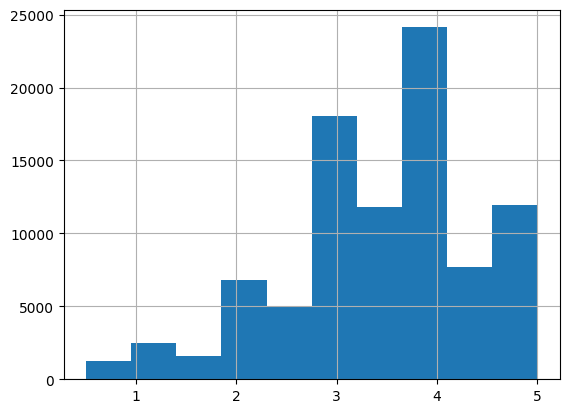

In [30]:
# 3점 ~ 5점에 많이 분포
train['rating'].hist()

### 모두 5점으로 예측하기

In [31]:
predictions = [5] * len(test)

In [32]:
mse = mean_squared_error(test['rating'], predictions)
rmse = np.sqrt(mse)
# 모든 데이터를 5로 예측할 경우, 이 모델은 평균적으로 1점 정도 틀림
rmse

1.8350041369074008

### 데이터의 평균으로 예측하기

In [34]:
# 전체 평균
rating_avg = train['rating'].mean()
rating_avg 

3.502798743870861

In [35]:
predictions = [rating_avg ] * len(test)

In [36]:
mse = mean_squared_error(test['rating'], predictions)
rmse = np.sqrt(mse)
# 모든 데이터를 5로 예측할 경우, 이 모델은 평균적으로 1점 정도 틀림
rmse

1.0439255333426836

### 사용자 평점 기반 예측하기 (각 사용자의 평균 평점으로 예측하기)

In [39]:
# 점수를 짜게 주는 사용자라면 모든 영화에 대해 점수를 짜게 줄 것이고, 후하게 준다면 후하게 준다는 가정
# 각 유저 별 평균 평점
users = train.groupby('userId')['rating'].mean().reset_index()
users

,userId,rating
0,1,4.333333
1,2,3.925926
2,3,2.529412
3,4,3.512690
4,5,3.627907
...,...,...
606,607,3.823171
607,608,3.135762
608,609,3.294118
609,610,3.696957


In [40]:
# 컬럼 이름 변경
users = users.rename(columns={'rating':'predict'})
users[:1]

,userId,predict
0,1,4.333333


In [42]:
# test 테이블에 있는 userId가 user 테이블에는 없을 수 있으므로
# test 테이블(왼쪽)을 기준으로 하여 userId 데이터가 제외되지 않도록 함
predict_by_users = test.merge(users, how='left', on='userId')
predict_by_users

,userId,movieId,rating,timestamp,predict
0,294,610,4.0,2000-08-18 21:24:11,2.622785
1,432,44759,3.0,2011-09-05 17:27:08,3.656904
2,112,253,4.5,2017-12-23 00:45:15,3.532787
3,536,457,3.0,1996-05-23 08:25:06,3.388889
4,282,6708,4.0,2013-09-06 19:21:32,4.016355
...,...,...,...,...,...
10079,71,1210,3.0,1997-05-27 13:00:37,3.500000
10080,274,2700,4.0,2007-02-20 01:28:48,3.218098
10081,250,318,5.0,2005-07-13 01:23:34,4.180000
10082,398,3000,5.0,2011-07-21 00:19:52,4.153846


In [44]:
# train 데이터에는 userId가 없었는데, test 데이터에는 있을 수 있으므로 null 값 확인
# null이 없으므로 모두 잘 섞여 test 데이터에 있는 userId가 모두 train 데이터에 있음을 알 수 있음
predict_by_users.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
predict      0
dtype: int64

In [45]:
mse = mean_squared_error(predict_by_users['rating'], predict_by_users['predict'])
rmse = np.sqrt(mse)
# 각 사용자의 평균 평점으로 예측할 경우, 이 모델은 평균적으로 1점 정도 틀림
rmse

0.9427072875640361

In [46]:
# 표준 편차
# 데이터가 평균적으로 1점 정도 떨어져서 분산되어 있음
train['rating'].std()

1.0423931079854916

In [47]:
# 각 유저별 표준 편차
# 표준 편차가 작을수록 모든 영화에 대한 비슷한 평점을 준다는 것
# 그러므로 전체의 평균 평점보다는 각 유저의 평균 평점으로 예측을 해주는 것이 모델의 퀄리티를 높여줌
train.groupby('userId')['rating'].std()

userId
1       0.812523
2       0.805076
3       2.131798
4       1.342436
5       1.000554
          ...   
607     0.971596
608     1.087873
609     0.462497
610     0.855266
1000    0.000000
Name: rating, Length: 611, dtype: float64

In [48]:
train.groupby('userId')['rating'].std().mean()

0.9237582517066527

<Axes: >

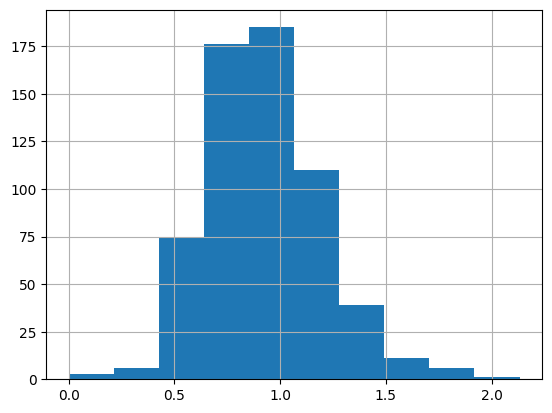

In [49]:
train.groupby('userId')['rating'].std().hist()

### 영화 평점 기반 예측하기 (각 영화의 평균 평점으로 예측하기)

In [50]:
# 사람들이 좋아하는 영화는 모두 좋아할 것이고, 싫어하는 영화는 모두 싫어할 것이라 가정
# 각 영화 별 평균 평점
movies = train.groupby('movieId')['rating'].mean().reset_index()
movies

,movieId,rating
0,1,3.906091
1,2,3.411458
2,3,3.139535
3,4,2.416667
4,5,3.093023
...,...,...
9376,193579,3.500000
9377,193581,4.000000
9378,193583,3.500000
9379,193585,3.500000


In [51]:
# 컬럼 이름 변경
movies = movies.rename(columns={'rating':'predict'})
movies[:1]

,movieId,predict
0,1,3.906091


In [53]:
# test 테이블에 있는 movieId가 movies 테이블에는 없을 수 있으므로
# test 테이블(왼쪽)을 기준으로 하여 movieId 데이터가 제외되지 않도록 함
predict_by_movies = test.merge(movies, how='left', on='movieId')
predict_by_movies.sample()

,userId,movieId,rating,timestamp,predict
5841,232,69640,4.0,2009-07-10 01:55:51,3.0


In [54]:
# train 데이터에는 movieId가 없었는데, test 데이터에는 있을 수 있으므로 null 값 확인
# 350개의 null값이 있음
predict_by_movies.isnull().sum()

userId         0
movieId        0
rating         0
timestamp      0
predict      350
dtype: int64

In [55]:
# NaN (Not a Number) : train 데이터에 없어 데이터가 비게 됨
predict_by_movies[predict_by_movies['predict'].isnull()]

,userId,movieId,rating,timestamp,predict
19,73,74647,1.0,2016-05-25 17:54:40,NaN
30,305,64501,5.0,2017-05-06 15:21:08,NaN
53,414,180045,4.0,2018-01-06 02:55:01,NaN
84,474,5440,3.0,2004-06-14 12:54:59,NaN
93,307,55729,3.0,2008-11-17 18:31:35,NaN
...,...,...,...,...,...
9916,18,171023,4.0,2017-09-16 22:12:23,NaN
9996,221,31610,4.0,2005-07-14 18:22:10,NaN
9999,89,164707,4.0,2018-03-07 07:50:54,NaN
10003,64,27869,4.5,2006-10-22 15:33:43,NaN


In [56]:
# 전체 데이터의 평균으로 null 값을 채워줌
predict_by_movies.loc[predict_by_movies['predict'].isnull(), 'predict'] = train['rating'].mean()

In [57]:
# null값이 사라짐
predict_by_movies.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
predict      0
dtype: int64

In [58]:
mse = mean_squared_error(predict_by_movies['rating'], predict_by_movies['predict'])
rmse = np.sqrt(mse)
# 각 영화의 평균 평점으로 예측할 경우, 이 모델은 평균적으로 1점 정도 틀림
rmse

0.9741459599735535